In [32]:
import yfinance as yf
import pandas as pd
import numpy as np
import matlab.engine
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
import math
solvers.options['show_progress'] = False

eng = matlab.engine.start_matlab()
quarters = [('-01-01', '-03-31'), ('-04-01', '-06-30'), ('-07-01', '-09-30'), ('-10-01', '-12-31')]
years = [
    ('2006-01-01','2006-12-31'), 
    ('2007-01-01','2007-12-31'),
    ('2008-01-01','2008-12-31'), 
    ('2009-01-01','2009-12-31'),
    ('2010-01-01','2010-12-31'), 
    ('2011-01-01','2011-12-31'),
    ('2012-01-01','2012-12-31'), 
    ('2013-01-01','2013-12-31'),
    ('2014-01-01','2014-12-31'), 
    ('2015-01-01','2015-12-31'),
    ('2016-01-01','2016-12-31'), 
    ('2017-01-01','2017-12-31'),    
    ('2018-01-01','2018-12-31'), 
    ('2019-01-01','2019-12-31'), 
    ('2020-01-01','2020-12-31')
]



mu_si = np.array([
4.17, 4.67, 5.09, 4.88,
5.07, 5.04, 4.95, 3.93,
3.26, 1.40, 1.87, 0.85,
0.08, 0.22, 0.17, 0.10,
0.08, 0.16, 0.17, 0.16,
0.15, 0.07, 0.02, 0.02,
0.02, 0.08, 0.10, 0.09,
0.08, 0.08, 0.04, 0.02,
0.07, 0.04, 0.02, 0.02,
0.02, 0.03, 0.01, -0.02, 
0.22, 0.33, 0.30, 0.33, 
0.54, 0.63, 0.98, 1.02, 
1.44, 1.63, 1.91, 2.13, 
2.42, 2.44, 2.35, 1.98, 
1.54, 1.12, 0.14, 0.12])/100
mu_cl = np.add(mu_si, [.03]*60)
mu_si = mu_si/252
mu_cl = mu_cl/252

mu_safe = {}
mu_credit = {}
rolling_quarter_yearly = []

for year_index, year in enumerate(years):
    cur_year = year[0][:4]
    for quarter_index in range(4):

        # if cur_year != '2020' or (cur_year == '2020' and quarter_index == 0):
        period_start = cur_year + quarters[quarter_index][0]
        period_end = str(int(cur_year) + 1) + quarters[quarter_index-1][1] if quarter_index != 0 else cur_year + quarters[quarter_index-1][1]
        rolling_quarter_yearly.append((period_start, period_end))

        mu_safe[cur_year + ' Q' + str(quarter_index + 1)] = mu_si[year_index*4 + quarter_index]
        mu_credit[cur_year + ' Q' + str(quarter_index + 1)] = mu_cl[year_index*4 + quarter_index]

mu_si = mu_safe
mu_cl = mu_credit 


In [33]:
# Tested and returns same as matlab
def compute_y(var):
    ones = eng.transpose(matlab.double([1]*len(var)))
    return eng.mldivide(matlab.double(var.values.tolist()), matlab.double(ones))._data.tolist()

# Tested and returns same as matlab
def compute_z(mean, variance):
    return eng.mldivide(matlab.double(variance.values.tolist()), eng.transpose(matlab.double(mean.values.tolist())))._data.tolist()

# np.dot values return the same as matlab for test data
def compute_abc(mean, variance):
    y = compute_y(variance)
    z = compute_z(mean, variance)
    ones = [1]*len(mean)
    # a = sum(eng.times(ones, matlab.double(y))._data)
    # b = sum(eng.times(ones, matlab.double(z))._data)
    # c = sum(eng.times(ones, matlab.double(mean.values.tolist()))._data)
    return np.sum(np.array(ones).conj()*y, axis=0), np.sum(np.array(ones).conj()*z, axis=0), np.sum(np.array(mean.values.tolist()).conj()*z, axis=0)
    # return a,b,c

# returns same values as matlab
def compute_mv_vars(mean, variance):
    a,b,c = compute_abc(mean, variance)
    sigma_mv = 1/(a**0.5)
    mu_mv = b/a
    nu_as = ((a*c - b**2)/a)**0.5
    return sigma_mv, mu_mv, nu_as

    
def is_solvent(portfolio, returns):
    return not any(y <= 0 for y in [1 + np.dot(portfolio, returns.iloc[day]) for day in range(len(returns))])

def is_long(portfolio):
    return not any(y < 0 for y in portfolio.tolist())

In [34]:
class Portfolio:
    def __init__(self, assets, name, start_date='2005-12-28', end_date='2021-01-05'):
        self.data = yf.download(assets, start_date, end_date)['Adj Close']
        self.data = self.data.reindex(columns=assets)
        self.returns = (self.data - self.data.shift(1))/self.data.shift(1)
        self.start_date = start_date
        self.end_date = end_date
        self.portfolio_name = name
        
    # Returns mean and variance of portfolio for period
    def get_mean_and_variance(self, period_start = None, period_end = None):
        
        # Can add checks to make sure dates are valid with data that is contained
        if period_start is not None and period_end is not None:
            return self.returns[period_start:period_end].mean(), self.returns[period_start:period_end].cov()
        
        return self.returns.mean(), self.returns.cov()

    # Returns minimum volatility portfolio allocation and parameters
    def get_minimum_volatility_portfolio_parameters(self, period_start = None, period_end = None):
        if period_start is None and period_end is None:
            period_start = self.start_date
            period_end = self.end_date

        m, V = Portfolio.get_mean_and_variance(self, period_start, period_end)

        sigma_mv, mu_mv, nu_as = compute_mv_vars(m, V)
        y = compute_y(V)

        f_mv = (sigma_mv**2)*np.array(y)

        return pd.Series(data=f_mv, index=self.data.columns), sigma_mv, mu_mv, nu_as

    # Returns safe tangent portfolio allocation if it exists and relevant parameters
    def get_safe_tangent_portfolio_parameters(self, mu_si, period_start = None, period_end = None):
        if period_start is None and period_end is None:
            period_start = self.start_date
            period_end = self.end_date

        m, V = Portfolio.get_mean_and_variance(self, period_start, period_end)

        f_mv, sigma_mv, mu_mv, nu_as = Portfolio.get_minimum_volatility_portfolio_parameters(self, period_start, period_end)

        if mu_mv == mu_si:
            return None
        
        nu_rf_squared = np.transpose(m - mu_si*np.ones(len(m)))@np.linalg.inv(V)@(m - mu_si*np.ones(len(m)))
        mu_diff = nu_rf_squared*sigma_mv**2/(mu_mv - mu_si)
        f_st = (mu_diff/nu_rf_squared)*np.linalg.inv(V) @ (m - mu_si*np.ones(len(m)))

        return pd.Series(data=f_st, index=self.data.columns), (np.transpose(f_st) @ V @ f_st)**0.5, (np.transpose(m) @ f_st), nu_rf_squared**0.5

    def get_credit_tangent_portfolio_parameters(self, mu_cl, period_start = None, period_end = None):
        if period_start is None and period_end is None:
            period_start = self.start_date
            period_end = self.end_date

        m, V = Portfolio.get_mean_and_variance(self, period_start, period_end)

        f_mv, sigma_mv, mu_mv, nu_as = Portfolio.get_minimum_volatility_portfolio_parameters(self, period_start, period_end)

        if mu_mv == mu_cl:
            return None

        nu_rf_squared = np.transpose(m - mu_cl*np.ones(len(m)))@np.linalg.inv(V)@(m - mu_cl*np.ones(len(m)))
        mu_diff = nu_rf_squared*sigma_mv**2/(mu_mv - mu_cl)
        f_ct = (mu_diff/nu_rf_squared)*np.linalg.inv(V) @ (m - mu_cl*np.ones(len(m)))

        return pd.Series(data=f_ct, index=self.data.columns), (np.transpose(f_ct) @ V @ f_ct)**0.5, (np.transpose(m) @ f_ct), nu_rf_squared**0.5
        
    def get_long_tangent_portfolio(self, mu_si, period_start=None, period_end=None):
        if period_start is None and period_end is None:
            period_start = self.start_date
            period_end = self.end_date

        m, V = Portfolio.get_mean_and_variance(self, period_start, period_end)

        mu_start = min(m)
        mu_end = max(m)
        step_size = (mu_end - mu_start)/300

        long_mus = np.arange(mu_start, mu_end + step_size, step_size)

        # Long Frontier
        Q = matrix(V.values, tc='d')
        z = matrix(np.zeros((len(V))).tolist(), tc='d')
        I = matrix((-1*np.identity(len(V))), tc='d')
        A = matrix(np.array([np.ones((len(V))).tolist(), m.values.tolist()]), tc='d')

        nu_ca = (None, None, None, -100)
        
        # Will need to adjust for time periods longer than a year
        year = period_start[:4]

        elf_portfolios = []

        for cur_mu in long_mus:
            deq = matrix(np.array([1, cur_mu]), tc='d')
            sol = solvers.qp(Q, z, I, z, A, deq)
            current_long_allocation = np.reshape(np.array(sol['x']), (len(m)))            

            elf_portfolios.append(current_long_allocation)

            sigma_lf = (np.matmul(np.matmul(current_long_allocation, V.values), np.reshape(current_long_allocation, (len(current_long_allocation),1)))[0])**0.5
            
            # Finding capital allocation line with greatest slope
            curNu_ca = (cur_mu - mu_si)/sigma_lf

            if curNu_ca > nu_ca[-1]:
                elf_portfolios = [current_long_allocation]
                nu_ca = (current_long_allocation, sigma_lf, cur_mu, curNu_ca)

        elf_portfolios = [p*nu_ca[0] for p in np.arange(0, 1, 100)] + elf_portfolios

        return nu_ca, elf_portfolios

In [35]:
groupA = Portfolio(['VFIAX', 'VBTLX', 'VGSLX'], 'Group A')
groupAB = Portfolio(['VFIAX', 'VBTLX', 'VGSLX', 'VIMAX', 'VSMAX', 'VGHCX'], 'Group AB')
groupABC = Portfolio(['VFIAX', 'VBTLX', 'VGSLX', 'VIMAX', 'VSMAX', 'VGHCX', 'AMZN', 'WMT', 'CVS'], 'Group ABC')

[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  9 of 9 completed


### Task 2

In [36]:

tangent_allocations = {'Safe': {}, 'Credit': {}, 'Long': {}}

elf_allocations = {}

vfiax_price = []

for rolling_index, (period_start, period_end) in enumerate(rolling_quarter_yearly):
    print(rolling_index, end=' ')      

    starting_year_and_quarter = period_start[0:4] + ' Q' + str((rolling_index % 4) + 1)

    st_params = groupABC.get_safe_tangent_portfolio_parameters(mu_si[starting_year_and_quarter], period_start, period_end)
    ct_params = groupABC.get_credit_tangent_portfolio_parameters(mu_cl[starting_year_and_quarter], period_start, period_end)
    lt_params, elf_portfolios = groupABC.get_long_tangent_portfolio(mu_si[starting_year_and_quarter], period_start, period_end)
    
    tangent_allocations['Safe'][starting_year_and_quarter] = st_params
    tangent_allocations['Credit'][starting_year_and_quarter] = ct_params
    tangent_allocations['Long'][starting_year_and_quarter] = lt_params

    elf_allocations[starting_year_and_quarter] = elf_portfolios

    vfiax_price.append(groupABC.data[period_start:period_end]['VFIAX'][0])

vfiax_price = (np.array(vfiax_price) - min(vfiax_price))/(max(vfiax_price) - min(vfiax_price))


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 

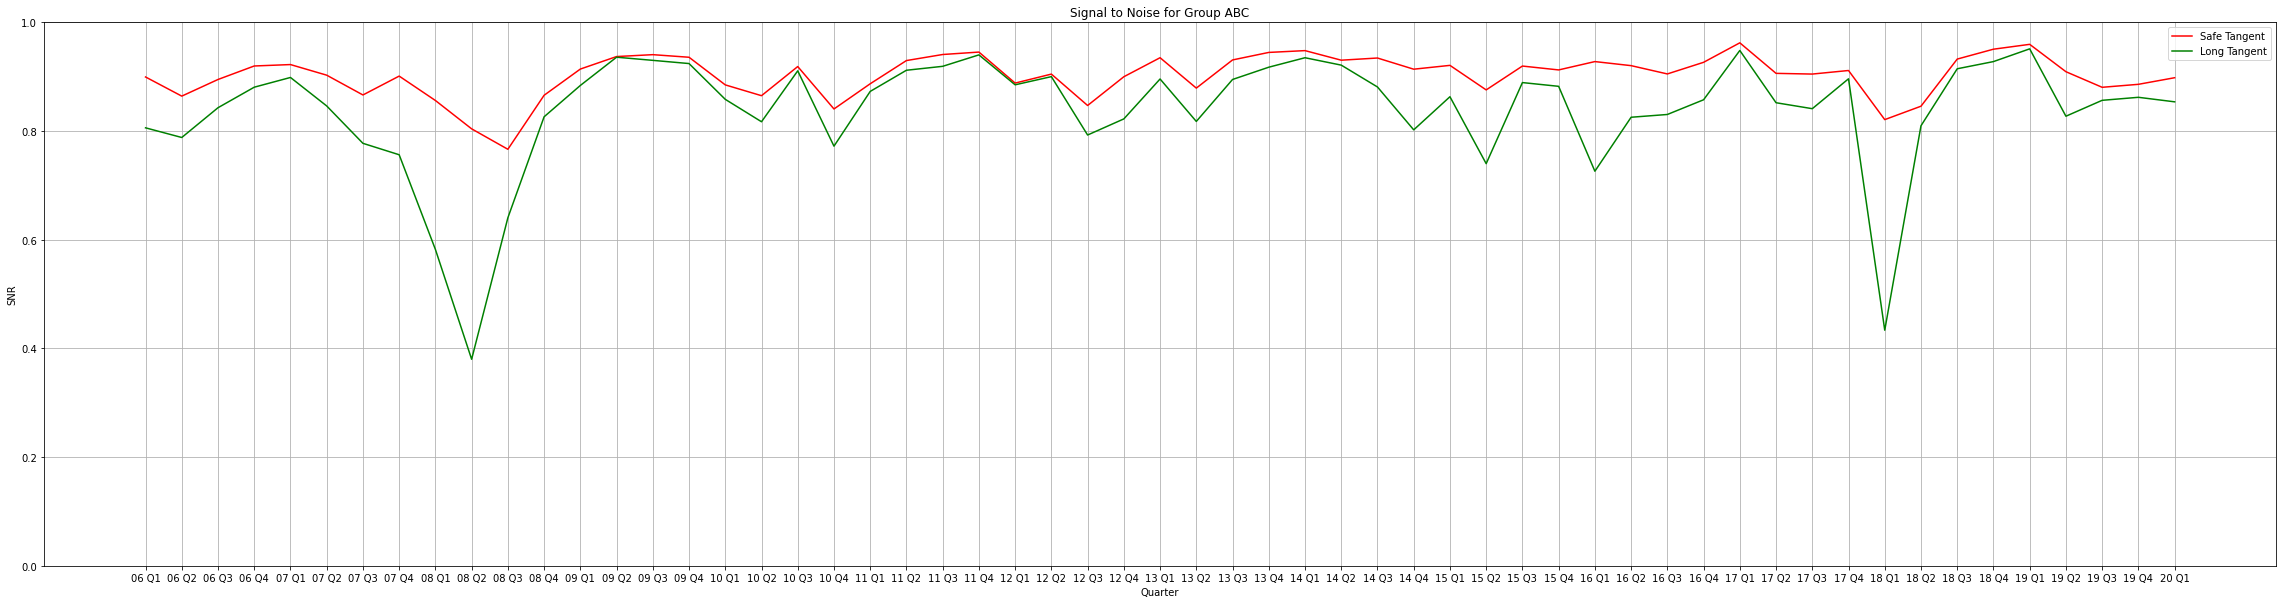

In [37]:
SNR_st = []
SNR_lt = []
rolling_quarter_index = []

for rolling_index, (period_start, period_end) in enumerate(rolling_quarter_yearly[:57]):
    starting_year_and_quarter = period_start[0:4] + ' Q' + str((rolling_index % 4) + 1)

    rolling_quarter_index.append(starting_year_and_quarter[2:])

    st_params = tangent_allocations['Safe'][starting_year_and_quarter]
    lt_params = tangent_allocations['Long'][starting_year_and_quarter]

    m, V = groupABC.get_mean_and_variance(period_start, period_end)

    days = len(groupABC.returns[period_start:period_end])
    uniformWeights = 1/ days
    wBar = np.sum(np.square(np.ones(days) * uniformWeights))

    SN_st = 0
    SN_lt = 0

    if st_params is not None:

        f_st, sigma_st, mu_st, _ = st_params
        SN_st = mu_st**2/(wBar*sigma_st**2 + mu_st**2)

    if lt_params is not None:

        f_lt, sigma_lt, mu_lt, _ = lt_params
        SN_lt = mu_lt**2/(wBar*sigma_lt**2 + mu_lt**2)

    SNR_st.append(SN_st)
    SNR_lt.append(SN_lt)

plt.figure(num = 0, figsize=(40,10))

plt.plot(rolling_quarter_index, SNR_st, 'r', label='Safe Tangent')
plt.plot(rolling_quarter_index, SNR_lt, 'g', label='Long Tangent')
plt.title('Signal to Noise for Group ABC')
plt.ylabel('SNR')
plt.xlabel('Quarter')
plt.ylim((0,1))
plt.grid()
plt.legend()
plt.show()



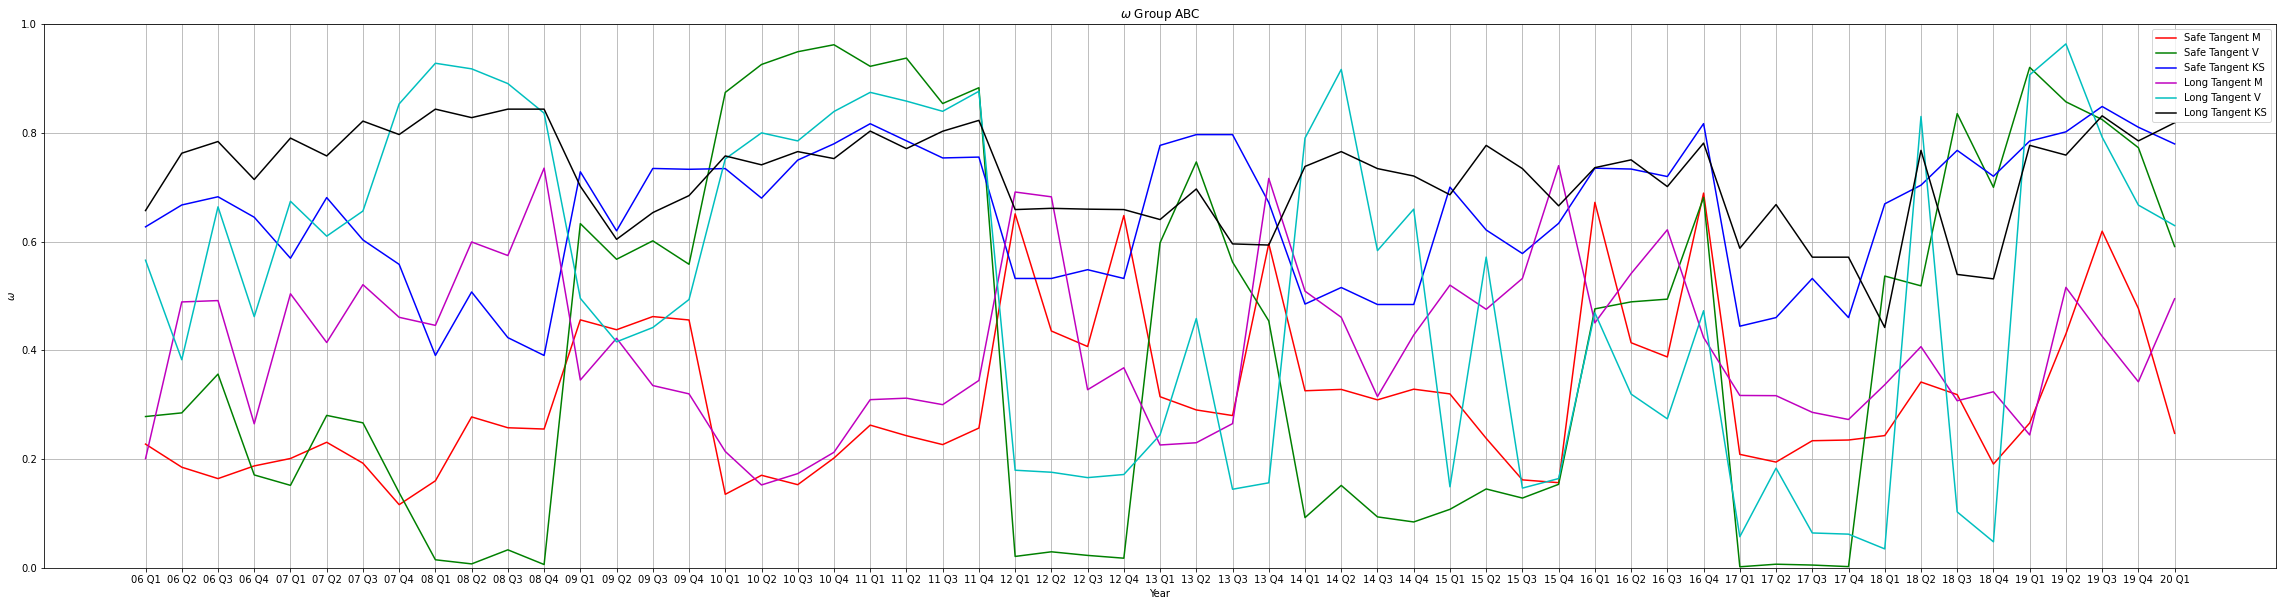

In [38]:
from scipy import stats

omega_m_st = []
omega_v_st = []
omega_ks_st = []

omega_m_lt = []
omega_v_lt = []
omega_ks_lt = []

for rolling_index, (period_start, period_end) in enumerate(rolling_quarter_yearly[:57]):
    m_st = 10000
    v_st = 10000
    ks_st = 10000

    m_lt = 10000
    v_lt = 10000
    ks_lt = 10000

    for i in range(3):

        cur_year_and_quarter = period_start[:4] + ' Q' + str((rolling_index + i) % 4 + 1)

        for j in range(i+1, 4):

            other_year_and_quarter = period_start[:4] + ' Q' + str(j+1)
            
            st1 = tangent_allocations['Safe'][cur_year_and_quarter]
            st2 = tangent_allocations['Safe'][other_year_and_quarter]

            if st1 is not None and st2 is not None:

                f_st1, sigma_st1, mu_st1, _ = st1
                f_st2, sigma_st2, mu_st2, _ = st2

                p1_start = period_start[:4] + quarters[i][0]
                p1_end = period_start[:4] + quarters[i][1]

                p2_start = period_start[:4] + quarters[j][0]
                p2_end = period_start[:4] + quarters[j][1]

                cur_quarter_returns = groupABC.returns[p1_start:p1_end]
                other_quarter_returns = groupABC.returns[p2_start:p2_end]

                D1 = len(cur_quarter_returns)
                D2 = len(other_quarter_returns)

                m1, V1 = groupABC.get_mean_and_variance(p1_start, p1_end)

                m1 = np.matmul(np.transpose(m1), f_st1)
                v1 = np.matmul(np.matmul(np.transpose(f_st1), V1.values), f_st1)

                m2, V2 = groupABC.get_mean_and_variance(p2_start, p2_end)

                m2 = np.matmul(np.transpose(m2), f_st2)
                v2 = np.matmul(np.matmul(np.transpose(f_st2), V2.values), f_st2)

                m_st = min(1/(1 + (m1 - m2)**2/(v1/D1 + v2/D2)), m_st)
                v_st = min((4*v1*v2)/(v1+v2)**2, v_st)
                ks_st = min(1 - stats.ks_2samp((cur_quarter_returns*f_st1).mean(axis=1), (other_quarter_returns*f_st2).mean(axis=1))[0], ks_st)

            lt1 = tangent_allocations['Long'][cur_year_and_quarter]
            lt2 = tangent_allocations['Long'][other_year_and_quarter]

            if lt1 is not None and lt2 is not None:
                p1_start = period_start[:4] + quarters[i][0]
                p1_end = period_start[:4] + quarters[i][1]

                p2_start = period_start[:4] + quarters[j][0]
                p2_end = period_start[:4] + quarters[j][1]

                f_lt1, sigma_lt1, mu_lt1, _ = lt1
                f_lt2, sigma_lt2, mu_lt2, _ = lt2

                cur_quarter_returns = groupABC.returns[p1_start:p1_end]
                other_quarter_returns = groupABC.returns[p2_start:p2_end]

                D1 = len(cur_quarter_returns)
                D2 = len(other_quarter_returns)

                m1, V1 = groupABC.get_mean_and_variance(p1_start, p1_end)

                m1 = np.matmul(np.transpose(m1), f_lt1)
                v1 = np.matmul(np.matmul(np.transpose(f_lt1), V1.values), f_lt1)

                m2, V2 = groupABC.get_mean_and_variance(p2_start, p2_end)

                m2 = np.matmul(np.transpose(m2), f_lt2)
                v2 = np.matmul(np.matmul(np.transpose(f_lt2), V2.values), f_lt2)

                m_lt = min(1/(1 + (m1 - m2)**2/(v1/D1 + v2/D2)), m_lt)
                v_lt = min((4*v1*v2)/(v1+v2)**2, v_lt)
                ks_lt = min(1 - stats.ks_2samp((cur_quarter_returns*f_lt1).mean(axis=1), (other_quarter_returns*f_lt2).mean(axis=1))[0], ks_lt)
            

    if m_st == 10000:
        m_st = 0
    if v_st == 10000:
        v_st = 0
    if ks_st == 10000:
        ks_st = 0

    omega_m_st.append(m_st)
    omega_v_st.append(v_st)
    omega_ks_st.append(ks_st)
    omega_m_lt.append(m_lt)
    omega_v_lt.append(v_lt)
    omega_ks_lt.append(ks_lt)


plt.figure(figsize=(40,10))
plt.title('$\omega$ Group ABC')
plt.ylabel('$\omega$')
plt.xlabel('Year')
plt.plot(rolling_quarter_index, omega_m_st, 'r', label='Safe Tangent M')
plt.plot(rolling_quarter_index, omega_v_st, 'g', label='Safe Tangent V')
plt.plot(rolling_quarter_index, omega_ks_st, 'b', label='Safe Tangent KS')
plt.plot(rolling_quarter_index, omega_m_lt, 'm', label='Long Tangent M')
plt.plot(rolling_quarter_index, omega_v_lt, 'c', label='Long Tangent V')
plt.plot(rolling_quarter_index, omega_ks_lt, 'k', label='Long Tangent KS')
plt.ylim((0,1))
plt.grid()
plt.legend()
plt.show()

In [39]:
def getProximityMetric(mean, Var, f_mean, f_var):
    # mean row vect
    # var nxn matrix
    # f_mean and f_var scalars
    ones = np.ones(mean.shape)
    invVar = np.linalg.inv(Var)
    a = ones.T @ invVar @ ones
    b = ones.T @ invVar @ mean
    c = mean.T @ invVar @ mean
    sig_mv = 1/ np.sqrt(a)
    mu_mv = b/a
    v_as = np.sqrt((a*c - b*b)/a)
    sig = np.sqrt(np.square(sig_mv) + np.square((f_mean - mu_mv)/v_as))
    return sig/f_var

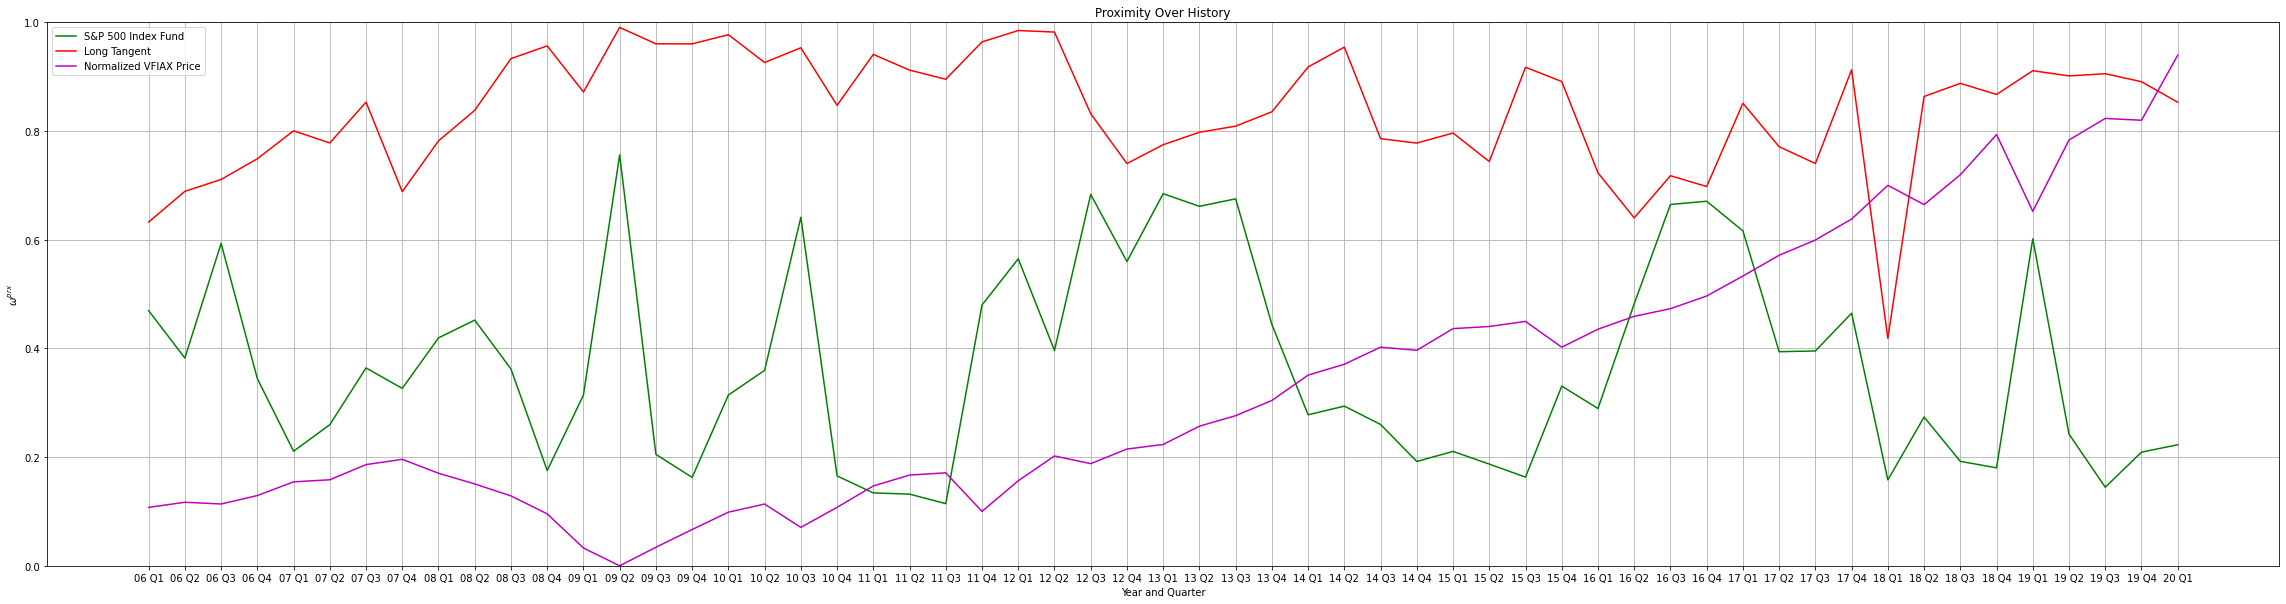

In [40]:
vfiax_prx = []
lt_prx = []
for rolling_index, (period_start, period_end) in enumerate(rolling_quarter_yearly[:57]):
    
    cur_year_and_quarter = period_start[0:4] + ' Q' + str((rolling_index % 4) + 1)

    f_lt, v_lt, m_lt, nu_lt = tangent_allocations['Long'][cur_year_and_quarter]

    m, V = groupABC.get_mean_and_variance(period_start, period_end)
    _, sigma_mv, mu_mv, nu_as = groupABC.get_minimum_volatility_portfolio_parameters(period_start, period_end)

    
    omega_prx_sp = (sigma_mv**2 + ((m['VFIAX'] - mu_mv)/nu_as)**2)**0.5/ (V['VFIAX']['VFIAX'])**0.5
    omega_prx_lt = getProximityMetric(m, V, m_lt, v_lt)

    vfiax_prx.append(omega_prx_sp)
    lt_prx.append(omega_prx_lt)


plt.figure(figsize=(40, 10))
plt.plot(rolling_quarter_index, vfiax_prx, 'g', label = 'S&P 500 Index Fund')
plt.plot(rolling_quarter_index, lt_prx, 'r', label = 'Long Tangent')
plt.plot(rolling_quarter_index, vfiax_price[:57], 'm', label='Normalized VFIAX Price')
plt.title('Proximity Over History')
plt.xlabel('Year and Quarter')
plt.ylabel('$\omega^{prx}$')
plt.ylim((0,1))
plt.legend()
plt.grid()
plt.show()


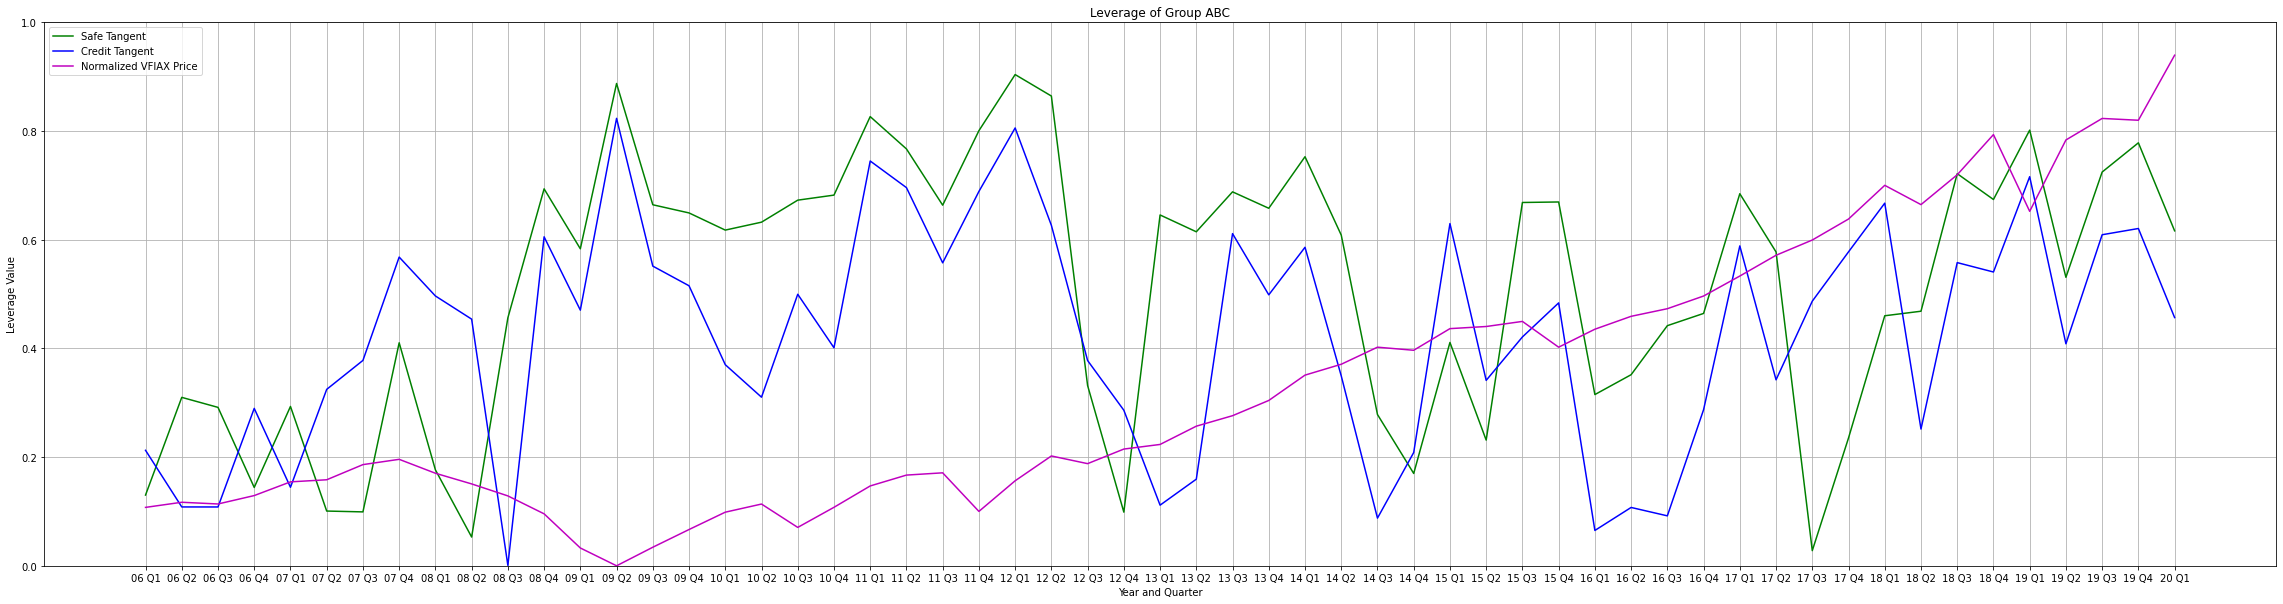

In [41]:
st_lev = []
ct_lev = []

for rolling_index, (period_start, period_end) in enumerate(rolling_quarter_yearly[:57]):
    
    cur_year_and_quarter = period_start[:4] + ' Q' + str((rolling_index % 4) + 1)

    st_params = tangent_allocations['Safe'][cur_year_and_quarter]
    ct_params = tangent_allocations['Credit'][cur_year_and_quarter]

    st_leverage = 0
    ct_leverage = 0

    if st_params is not None:
        st_norm = np.linalg.norm(st_params[0], 1)
        st_leverage = 2/(1+st_norm)
    
    if ct_params is not None:
        ct_norm = np.linalg.norm(ct_params[0], 1)
        ct_leverage = 2/(1+ct_norm)

    st_lev.append(st_leverage)
    ct_lev.append(ct_leverage)


plt.figure(figsize=(40,10))
plt.title('Leverage of Group ABC')
plt.ylabel('Leverage Value')
plt.xlabel('Year and Quarter')
plt.plot(rolling_quarter_index, st_lev, 'g', label='Safe Tangent')
plt.plot(rolling_quarter_index, ct_lev, 'b', label='Credit Tangent')
plt.plot(rolling_quarter_index, vfiax_price[:57], 'm', label='Normalized VFIAX Price')
plt.ylim((0,1))
plt.grid()
plt.legend()
plt.show()

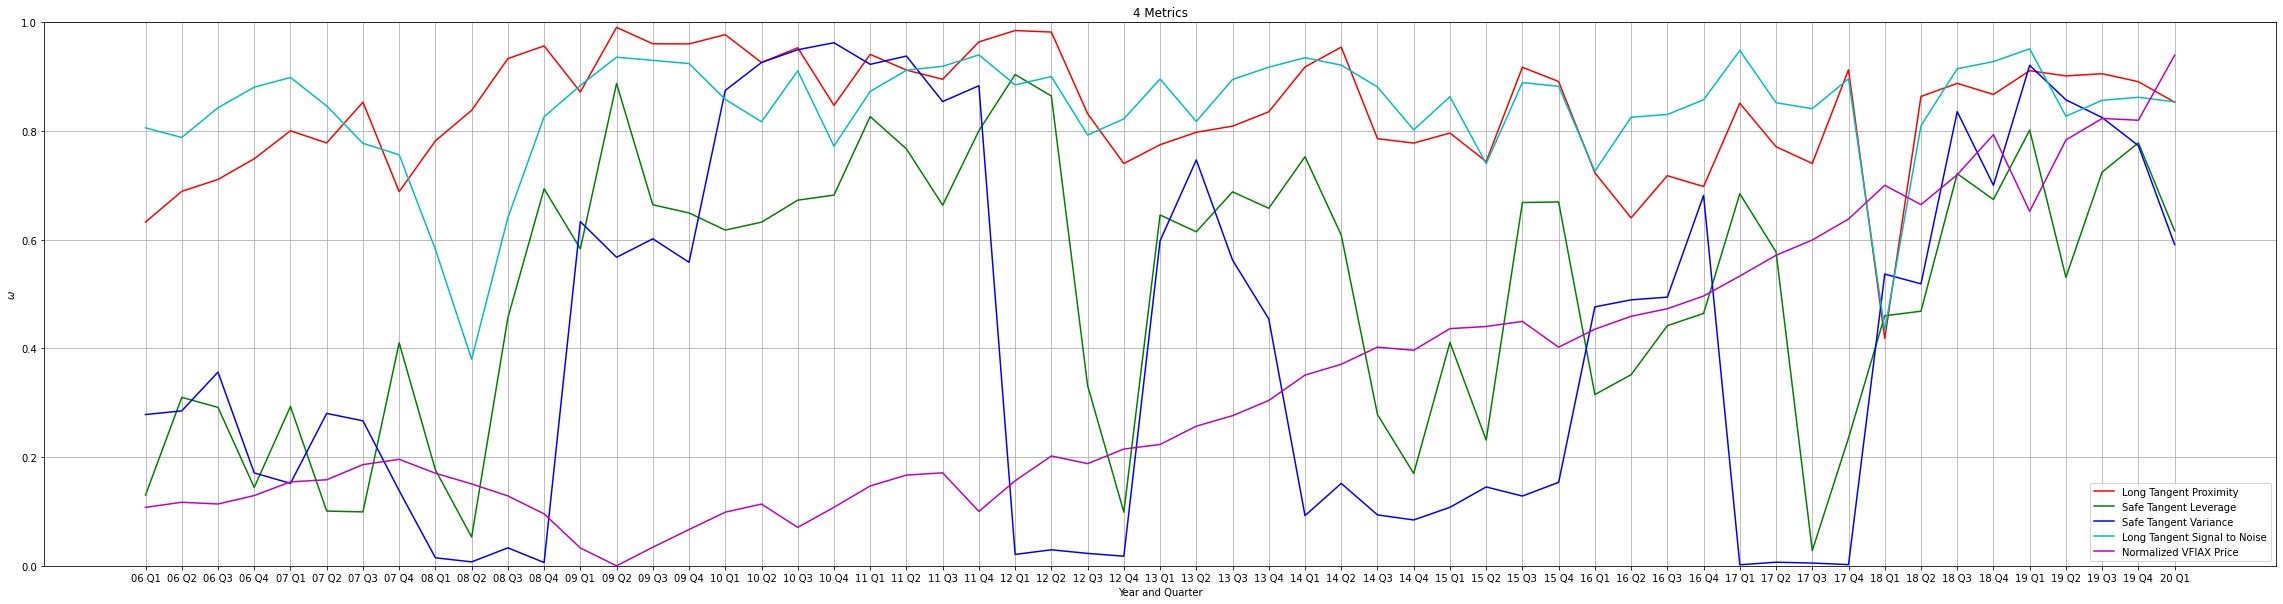

In [42]:

plt.figure(figsize=(40,10))
plt.plot(rolling_quarter_index, lt_prx, 'r', label= 'Long Tangent Proximity')
# plt.plot(rolling_quarter_index, ct_lev, 'm', label= 'Credit Tangent Leverage')
plt.plot(rolling_quarter_index, st_lev, 'g', label='Safe Tangent Leverage')
plt.plot(rolling_quarter_index, omega_v_st, 'b', label='Safe Tangent Variance')
plt.plot(rolling_quarter_index, SNR_lt, 'c', label='Long Tangent Signal to Noise')
plt.plot(rolling_quarter_index, vfiax_price[:57], 'm', label='Normalized VFIAX Price')

plt.ylabel('$\omega$')
plt.xlabel('Year and Quarter')
plt.title('4 Metrics')
plt.ylim((0,1))
plt.grid()
plt.legend()
plt.show()

### Task 3

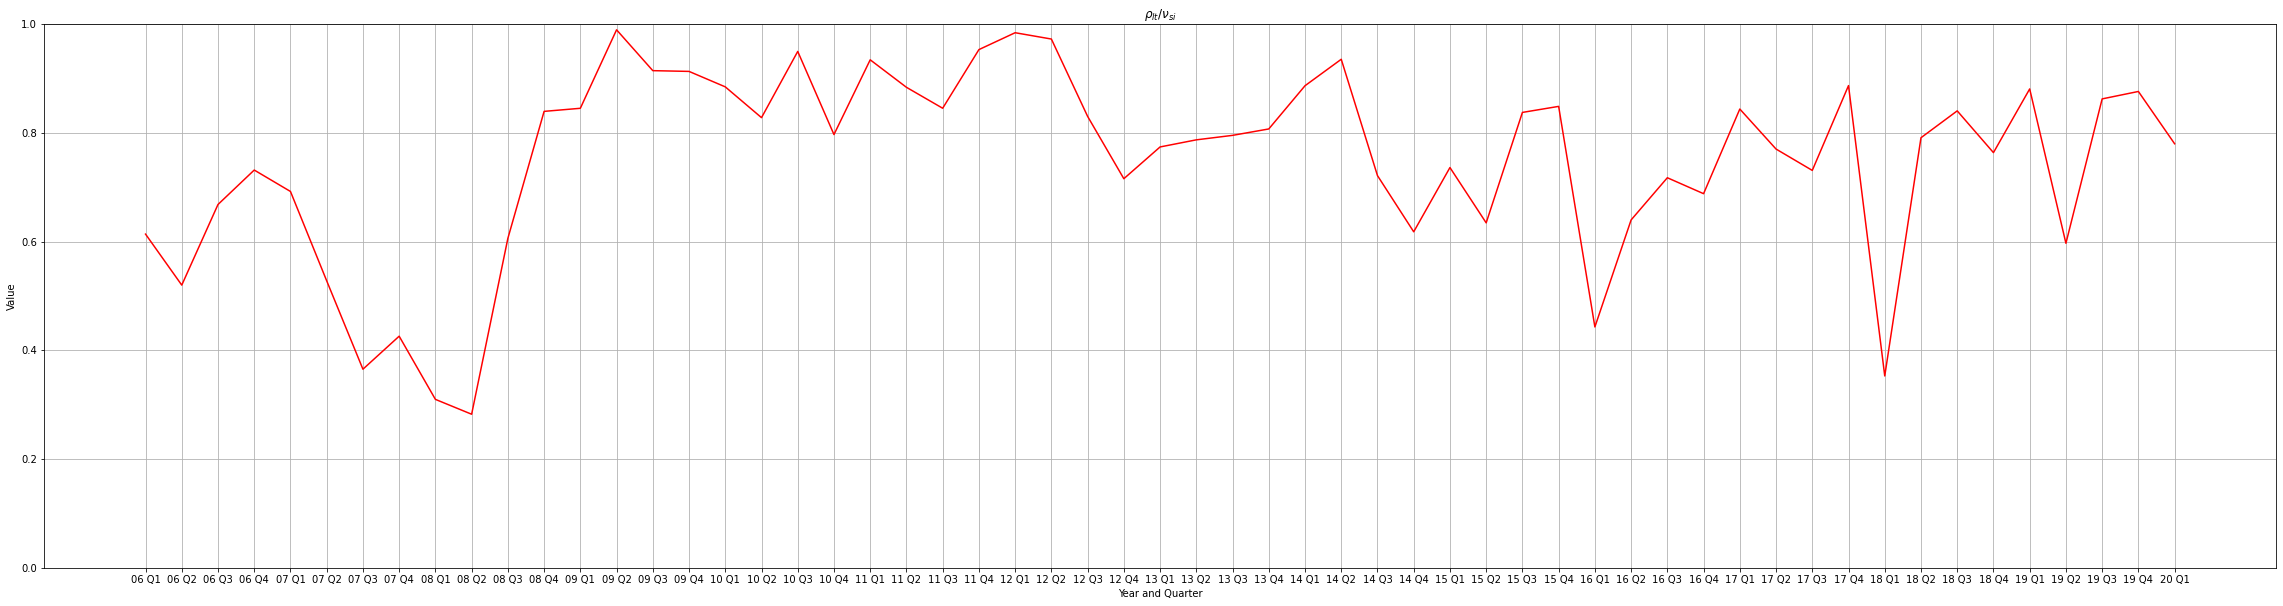

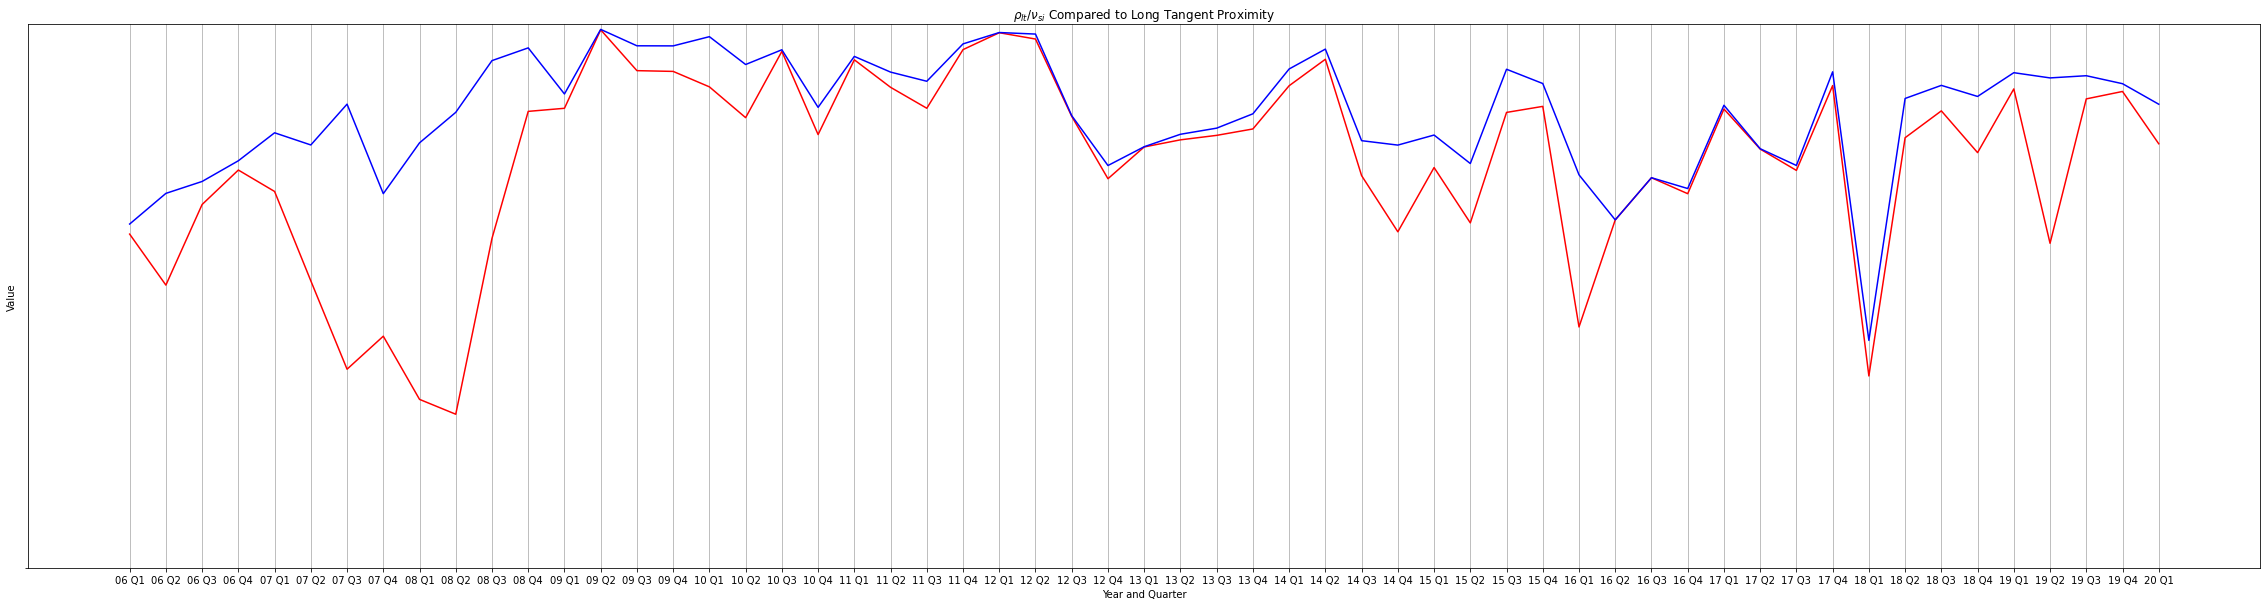

In [44]:
rho_over_nu = []
for rolling_index, (period_start, period_end) in enumerate(rolling_quarter_yearly[:57]):
    
    cur_year_and_quarter = period_start[:4] + ' Q' + str((rolling_index % 4) + 1)
    f_st, sigma_st, mu_st, nu_st = tangent_allocations['Safe'][cur_year_and_quarter]

    f_lt, sigma_lt, mu_lt, nu_lt = tangent_allocations['Long'][cur_year_and_quarter]

    m, V = groupABC.get_mean_and_variance(period_start, period_end)

    if mu_si[cur_year_and_quarter] < max(m):
        rho_over_nu.append(((mu_lt - mu_si[cur_year_and_quarter])/sigma_lt)/(nu_st))

    else:
        rho_over_nu.append(0)

plt.figure(figsize=(40,10))
plt.plot(rolling_quarter_index, rho_over_nu, 'r')
plt.title('$\\rho_{lt}/\\nu_{si}$')
plt.ylabel('Value')
plt.xlabel('Year and Quarter')
plt.grid()
plt.ylim((0,1))
plt.show()

plt.figure(figsize=(40,10))
plt.plot(rolling_quarter_index, rho_over_nu, 'r', '')
plt.plot(rolling_quarter_index, lt_prx, 'b')
plt.title('$\\rho_{lt}/\\nu_{si} $ Compared to Long Tangent Proximity')
plt.ylabel('Value')
plt.xlabel('Year and Quarter')
plt.grid()
plt.ylim((0,1))
plt.show()

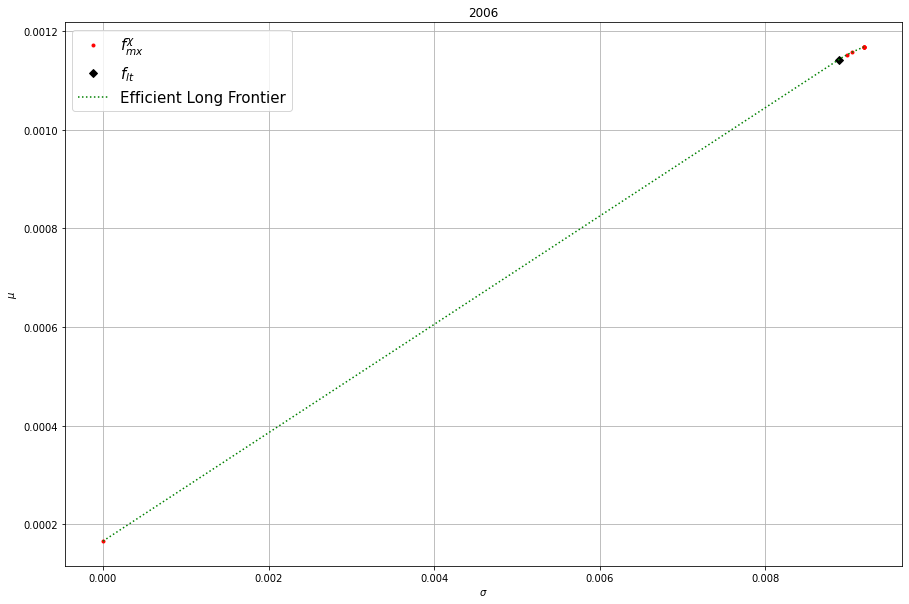

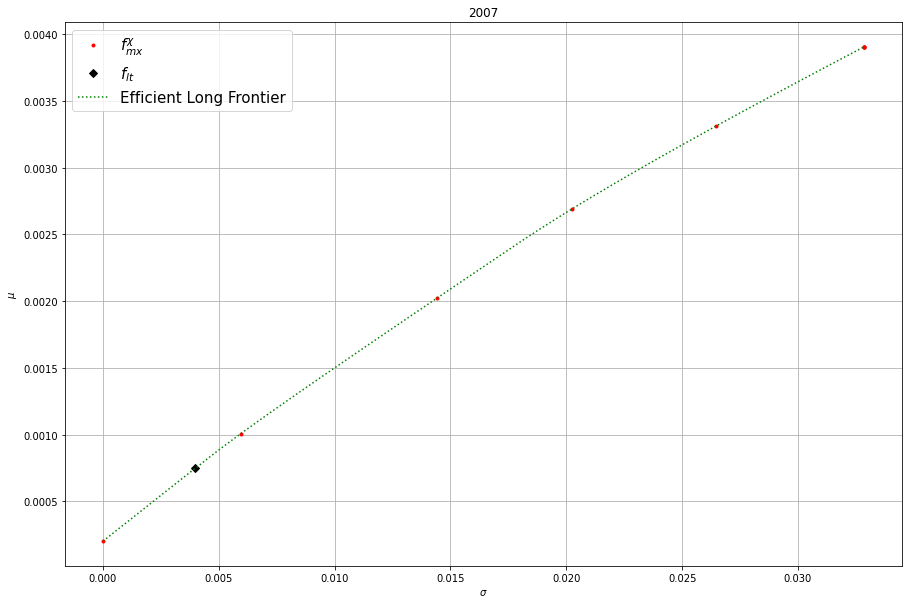

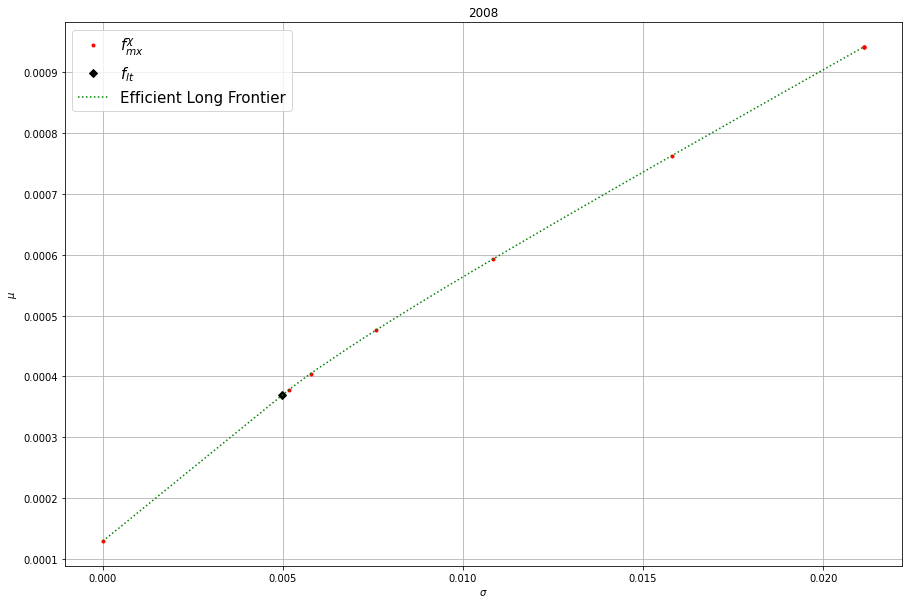

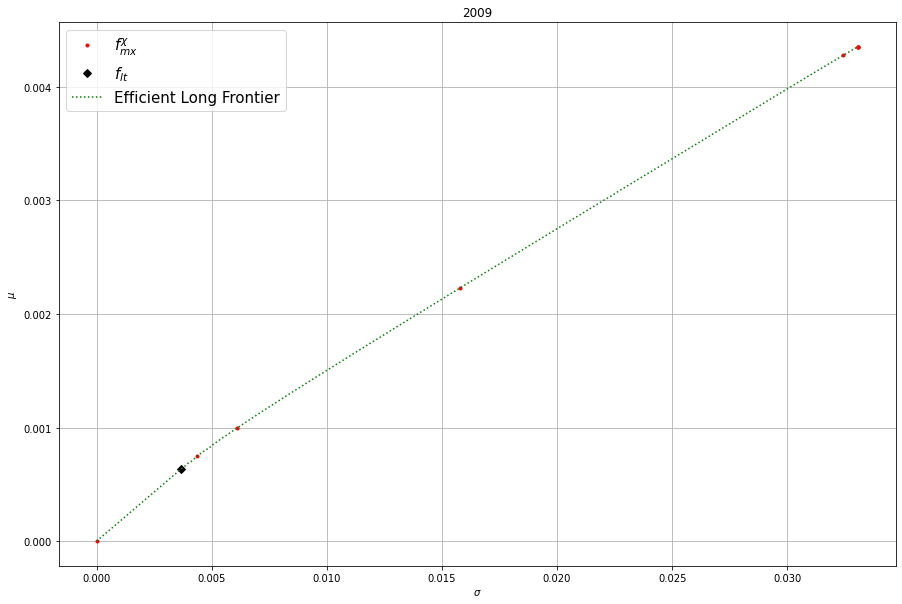

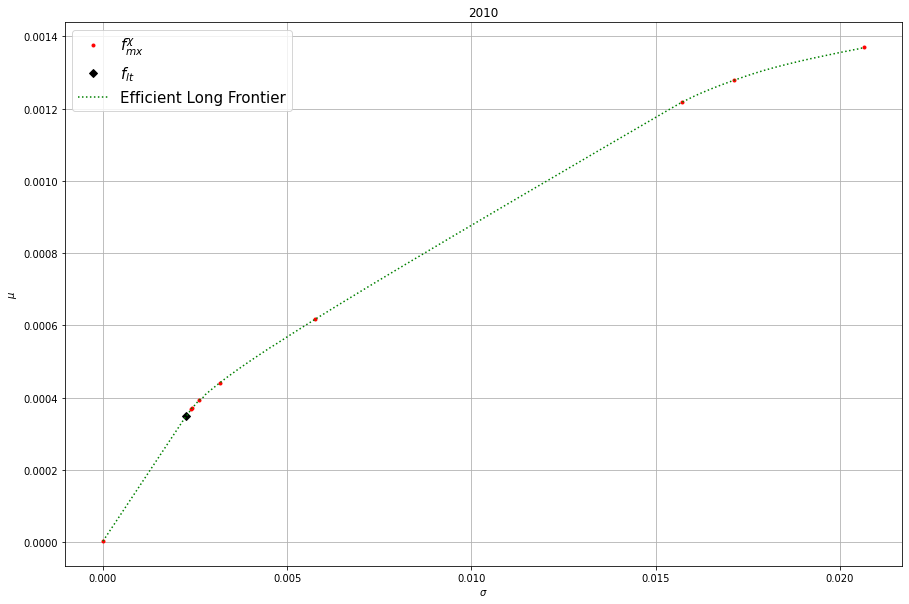

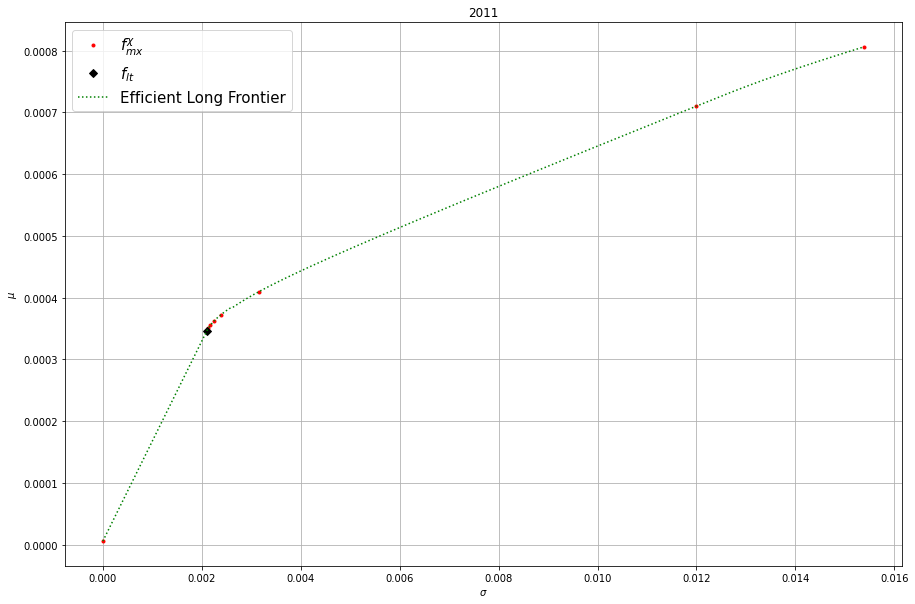

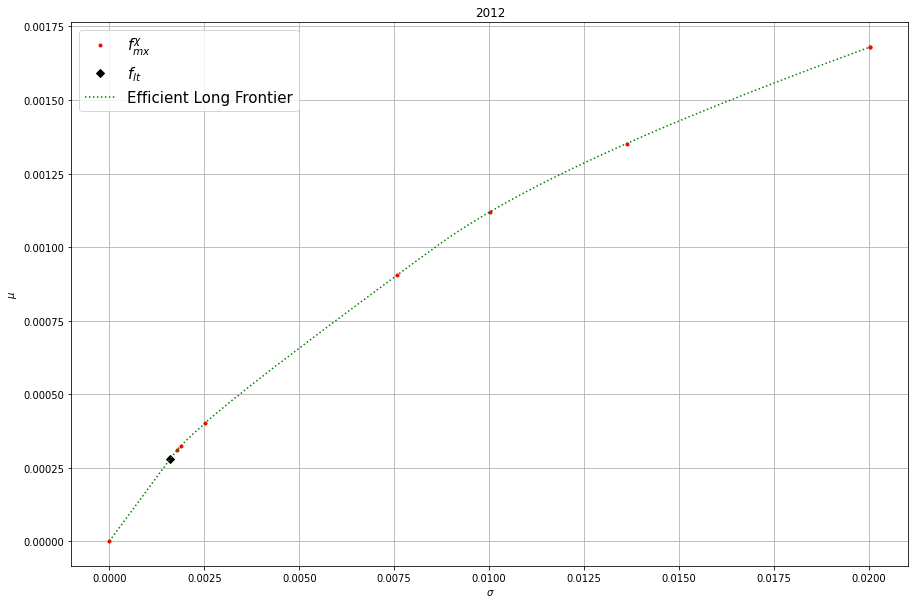

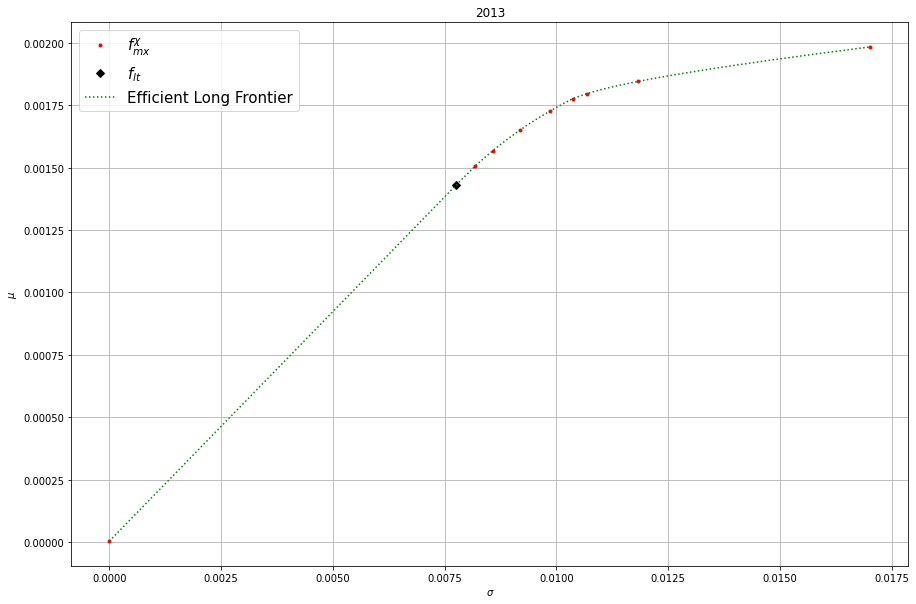

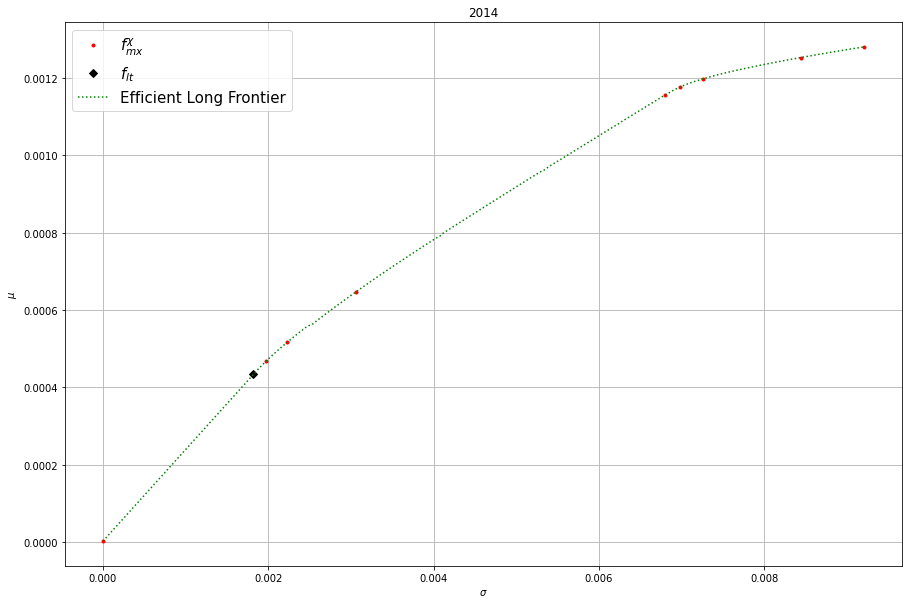

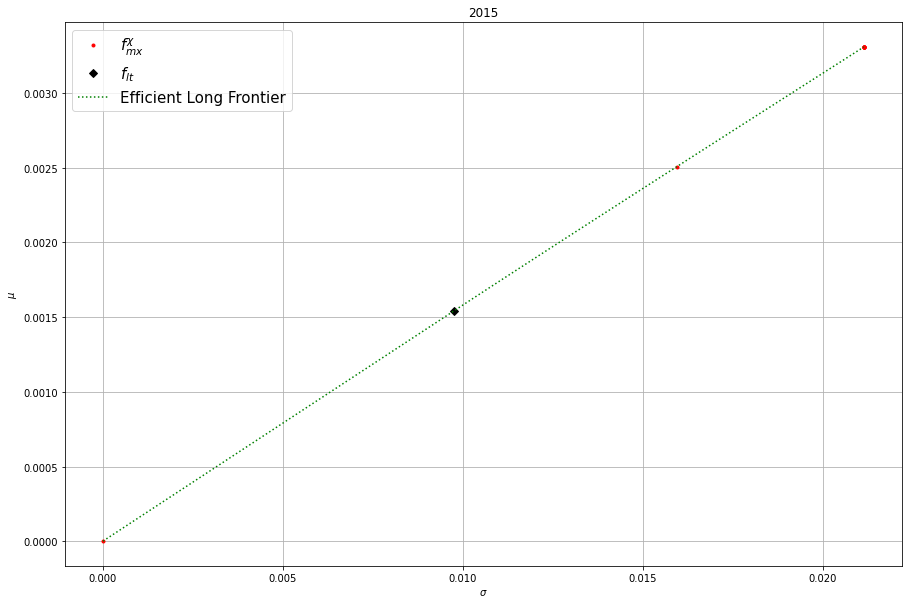

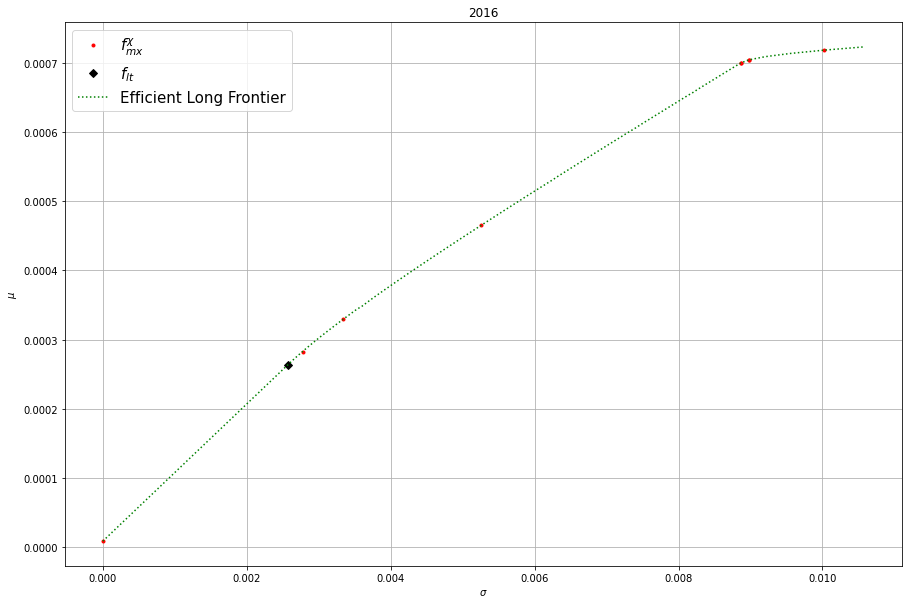

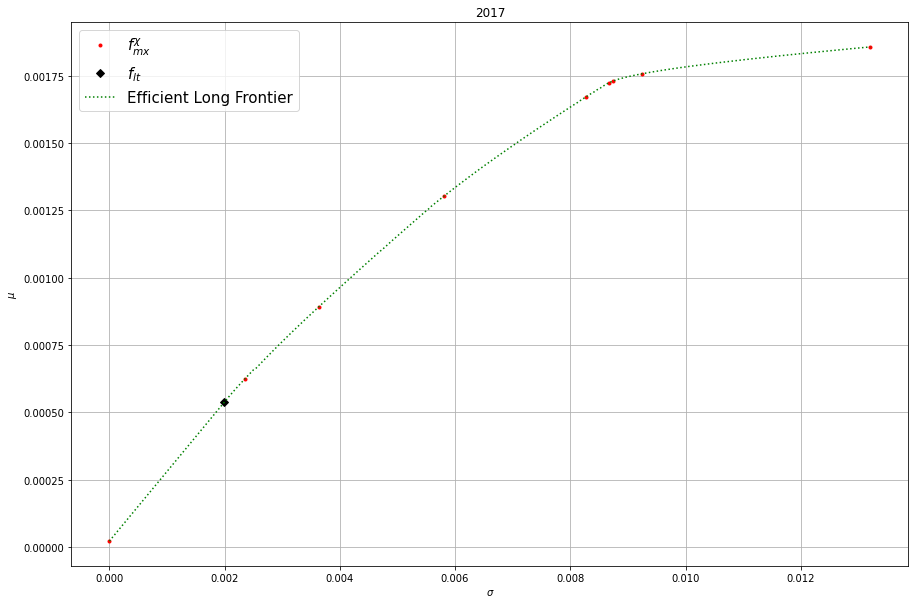

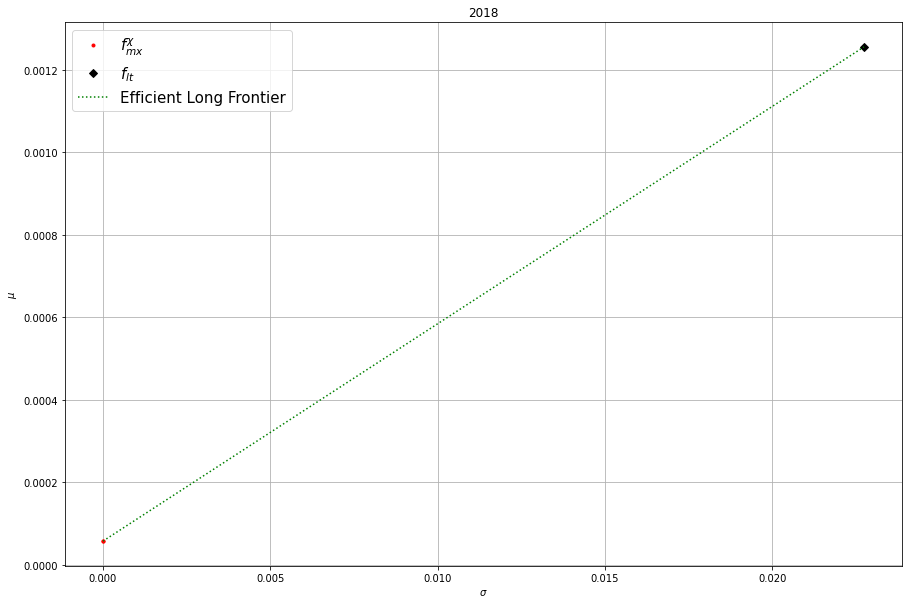

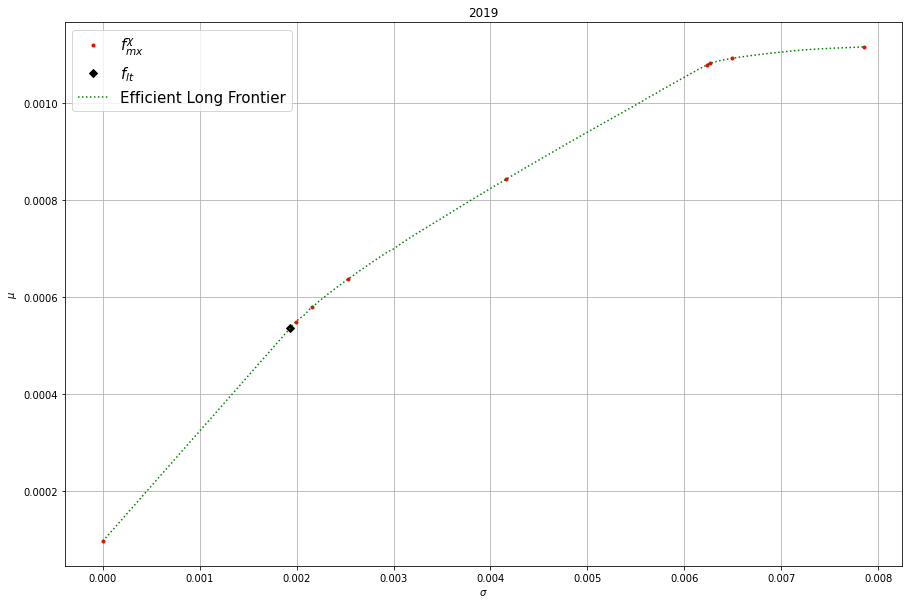

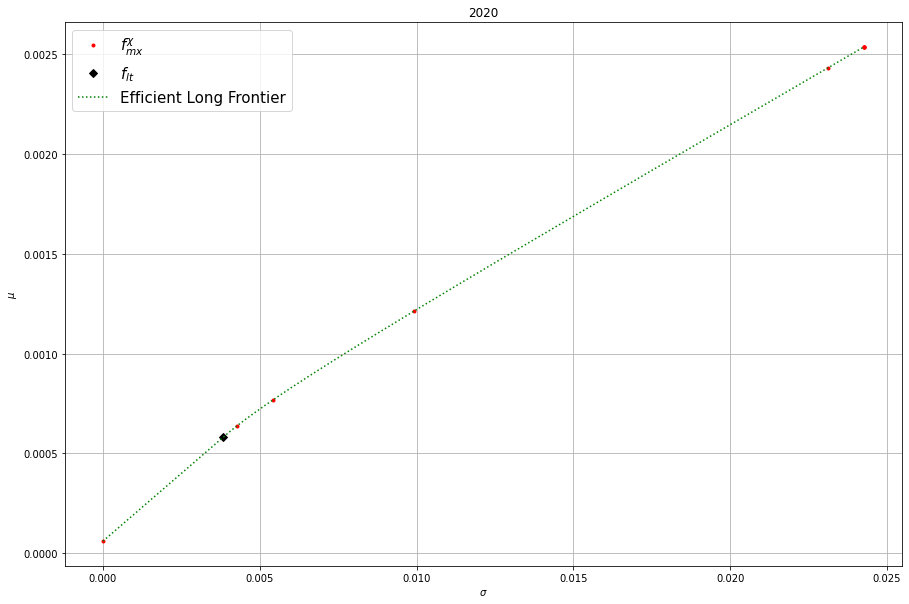

In [45]:
caution_coeffs = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]
allocations = {}

for rolling_index, (period_start, period_end) in enumerate(rolling_quarter_yearly[:57]):
    
    if rolling_index % 4 == 0:
        plt.figure(num=rolling_index, figsize=(15,10))

    cur_year_and_quarter = period_start[0:4] + ' Q' + str((rolling_index % 4) + 1)

    m, V = groupABC.get_mean_and_variance(period_start, period_end)

    f_lt, sigma_lt, mu_lt, nu_lt = tangent_allocations['Long'][cur_year_and_quarter]

    if mu_si[cur_year_and_quarter] < max(m):
        rho = (mu_lt - mu_si[cur_year_and_quarter])/sigma_lt 

        elf = elf_allocations[cur_year_and_quarter]

        safe_mu = mu_si[cur_year_and_quarter]

        allocations[cur_year_and_quarter] = []
        for c in caution_coeffs:
            chi = c*rho
            max_gamma = (-10, 0, 0, None, chi)

            for portfolio in elf:
                mu = safe_mu + np.transpose(m - safe_mu*np.ones(len(m))) @ portfolio
                sigma = (np.transpose(portfolio) @ V @ portfolio)**0.5

                

                gamma = np.log1p(mu) - 0.5*sigma**2 - chi*sigma

                if gamma > max_gamma[0]:
                    max_gamma = (gamma, mu, sigma, portfolio, chi)

            
            
            if rolling_index % 4 == 0:
                if c == 0:
                    plt.plot(max_gamma[2], max_gamma[1], 'r.', label='$f^{\chi}_{mx}$')
                else:
                    plt.plot(max_gamma[2], max_gamma[1], 'r.')
           
            allocations[cur_year_and_quarter].append((max_gamma[3:]))
            # plt.text(max_gamma[2], max_gamma[1], str(c))

    if rolling_index % 4 == 0:
        plt.plot(sigma_lt, mu_lt, 'kD', label='$f_{lt}$')
        plt.plot([(np.transpose(f) @ V @ f)**0.5 for f in elf], [safe_mu + np.transpose(m - safe_mu*np.ones(len(m))) @ f for f in elf], 'g:', label='Efficient Long Frontier')
        plt.title(cur_year_and_quarter[:4])
        plt.ylabel('$\mu$')
        plt.xlabel('$\sigma$')
        plt.grid()
        plt.legend(prop={'size':15})
        plt.show()

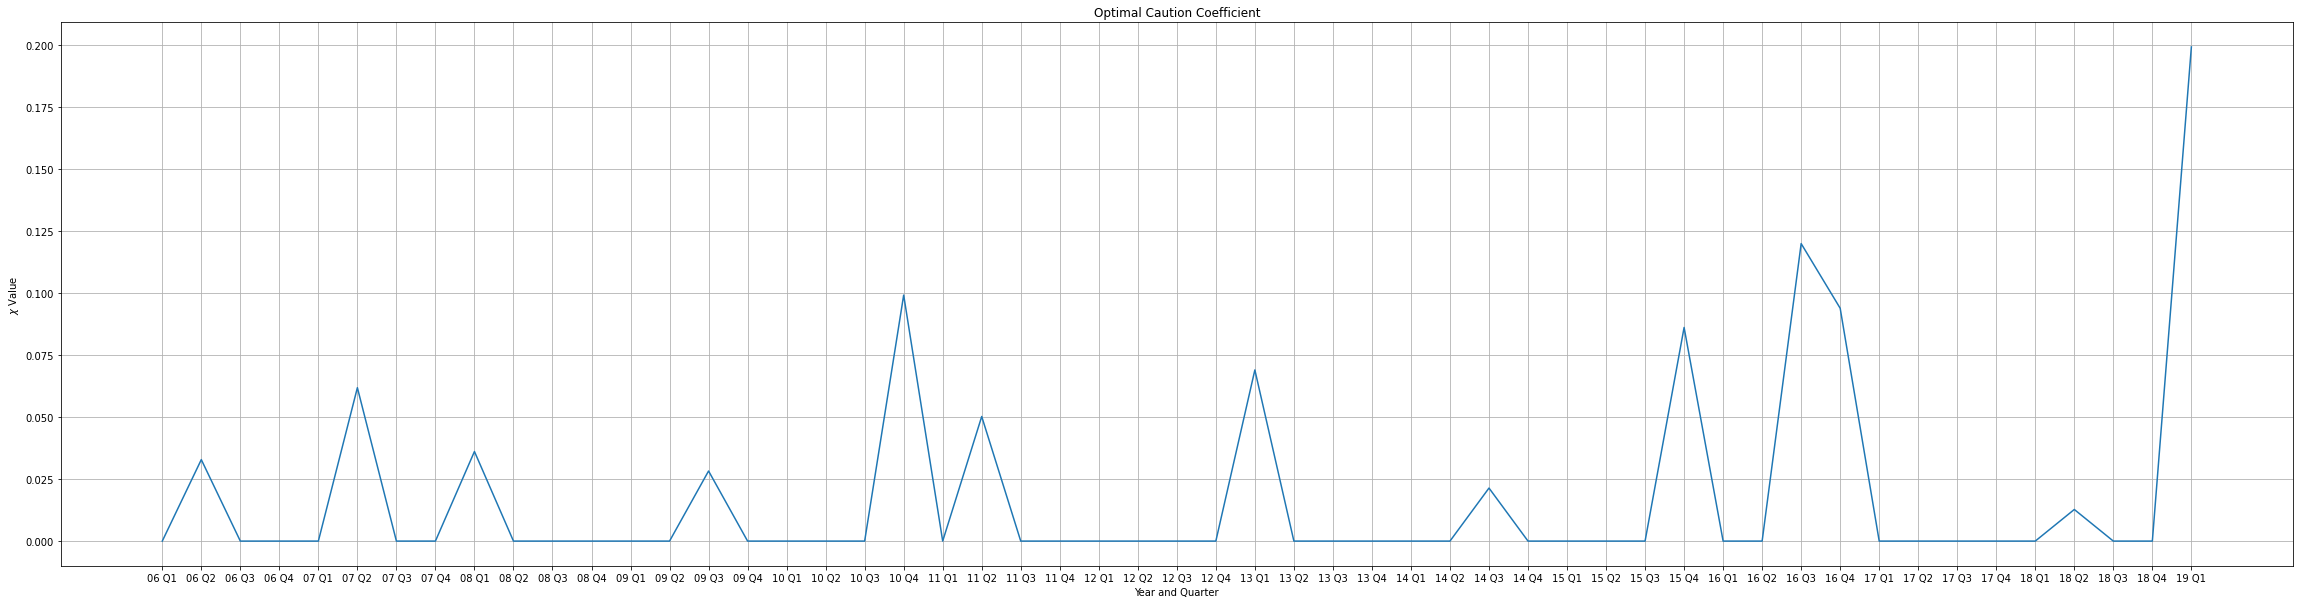

In [46]:
plt.figure(figsize=(40,10))
optimal_caution = {}
for rolling_index, (period_start, period_end) in enumerate(rolling_quarter_yearly[:57]):
    cur_year_and_quarter = period_start[0:4] + ' Q' + str((rolling_index % 4) + 1)
    portfolios = allocations[cur_year_and_quarter]

    next_history = rolling_quarter_yearly[rolling_index+1]
    next_year_and_quarter = next_history[0][0:4] + ' Q' + str(((rolling_index + 1) % 4) + 1)
    
    period_returns = groupABC.returns[next_history[0]:next_history[1]]

    mu = mu_si[next_year_and_quarter]

    best_returns = (-10,0)
    for p in portfolios:
        f, chi = p
        val = np.sum((period_returns.apply(lambda r: mu + np.transpose(r - mu*np.ones(len(r))) @ f, axis=1)).apply(np.log1p))

        if val > best_returns[0]:
            best_returns = (val, chi)
            
    optimal_caution[cur_year_and_quarter] = best_returns[1]


plt.plot(rolling_quarter_index[:53], list(optimal_caution.values())[:53])
plt.ylabel('$\chi$ Value')
plt.xlabel('Year and Quarter')
plt.title('Optimal Caution Coefficient')
plt.grid()
plt.show()

### PART 4

In [109]:
snrs = [SNR_lt, SNR_st]
iids = [omega_ks_lt, omega_ks_st, omega_m_lt, omega_m_st, omega_v_lt, omega_v_st]
prxs = [vfiax_prx, lt_prx]
levs = [ct_lev, st_lev]
b = np.array(list(optimal_caution.values())[1:53])

best_vals = (1, '')
for s, snr in enumerate(snrs):
    for ii, iid in enumerate(iids):
        for p, prx in enumerate(prxs):
            for l, lev in enumerate(levs):
                A = np.zeros((52,7))

                for i in range(A.shape[0]):
                    A[i,:] = [1, -snr[i+1], -iid[i+1], -prx[i+1], -prx[i], -lev[i+1], -lev[i]]

                ls_results = np.linalg.lstsq(A,b)[0]
                resids = np.sum(np.square(A@ls_results - b))
                
                if resids < best_vals[0]:
                    best_vals = (resids, str(s) + str(ii) + str(p) + str(l))


print(best_vals)

(0.06781153232883515, '1100')
ipykernel_launcher:17: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [154]:
A = np.zeros((52,7))

for i in range(A.shape[0]):
    A[i,:] = [1, -SNR_lt[i+1], -omega_v_st[i+1], -lt_prx[i+1], -lt_prx[i], -st_lev[i+1], -st_lev[i]] 

b = np.array(list(optimal_caution.values())[1:53])

ls_results = np.linalg.lstsq(A,b, rcond=0)[0]

vars = 'Alpha:SNR LT:Omega V ST:LT Proximity Current:LT Proximity Previous:ST Leverage Current:ST Leverage Previous'.split(':')
for i in range(len(ls_results)):
    print(f'{vars[i]}: {ls_results[i]}')

print('\nSquare Residuals Value:',np.sum(np.square(A@ls_results - b))) # Square residuals




Alpha: 0.05617861277027266
SNR LT: -0.027388488070041867
Omega V ST: -0.03758612476518372
LT Proximity Current: 0.051110400572657484
LT Proximity Previous: 0.048625820332308146
ST Leverage Current: -0.008468717018365443
ST Leverage Previous: -0.007202328805351666

Square Residuals Value: 0.06872343388433697


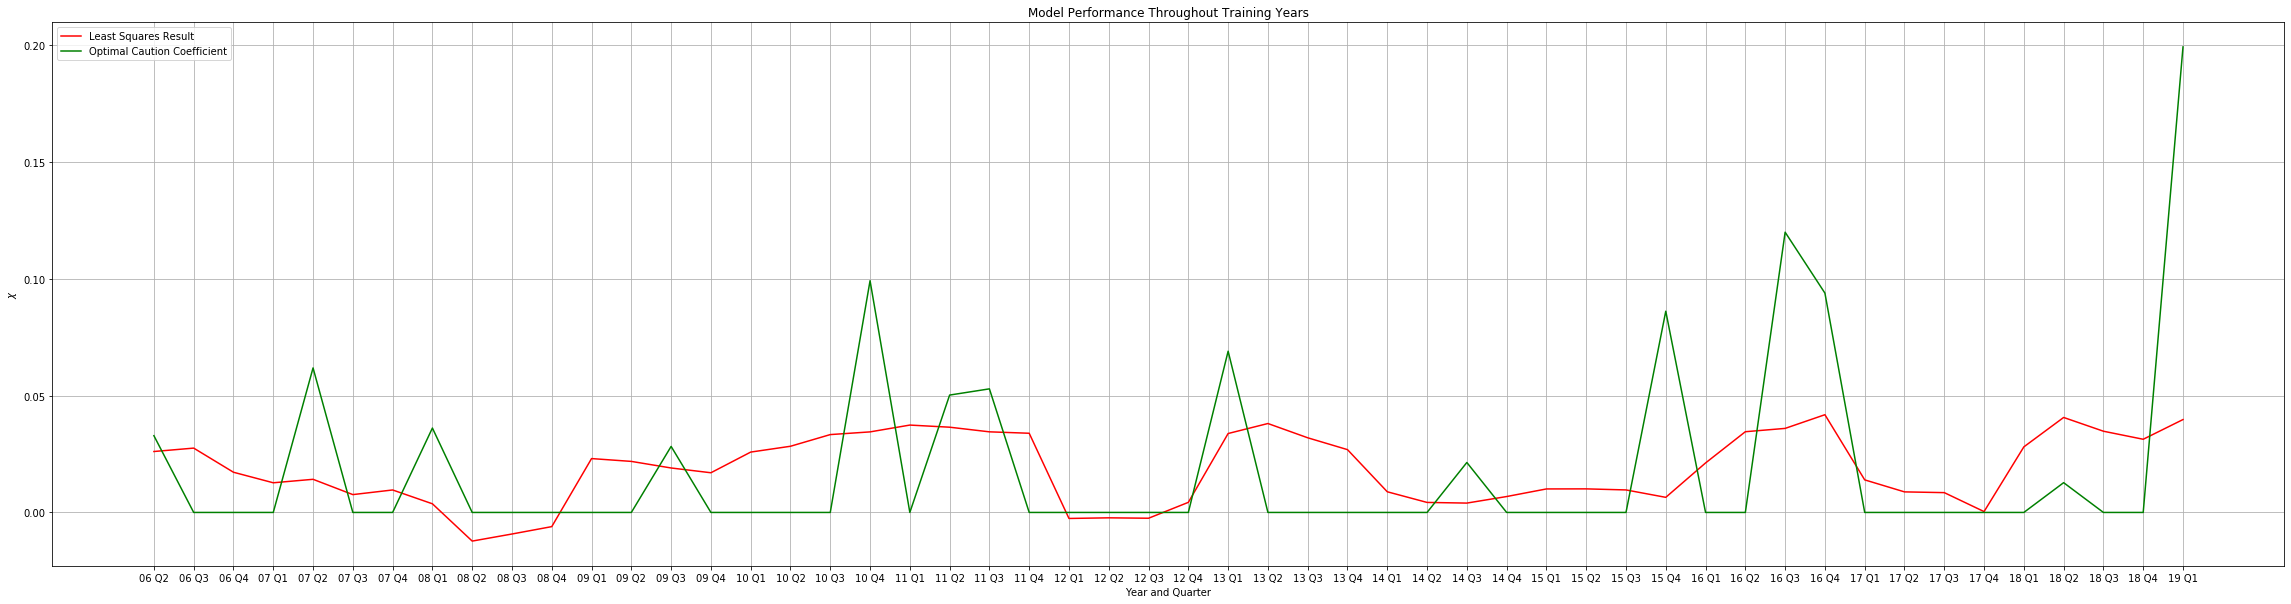

In [161]:
plt.figure(figsize=(40,10))
plt.plot(rolling_quarter_index[1:53], A@ls_results, 'r', label='Least Squares Result')
plt.plot(rolling_quarter_index[1:53], list(optimal_caution.values())[1:53], 'g', label='Optimal Caution Coefficient')
plt.ylabel('$\chi$')
plt.xlabel('Year and Quarter')
plt.title('Model Performance Throughout Training Years')
plt.grid()
plt.legend()
plt.show()

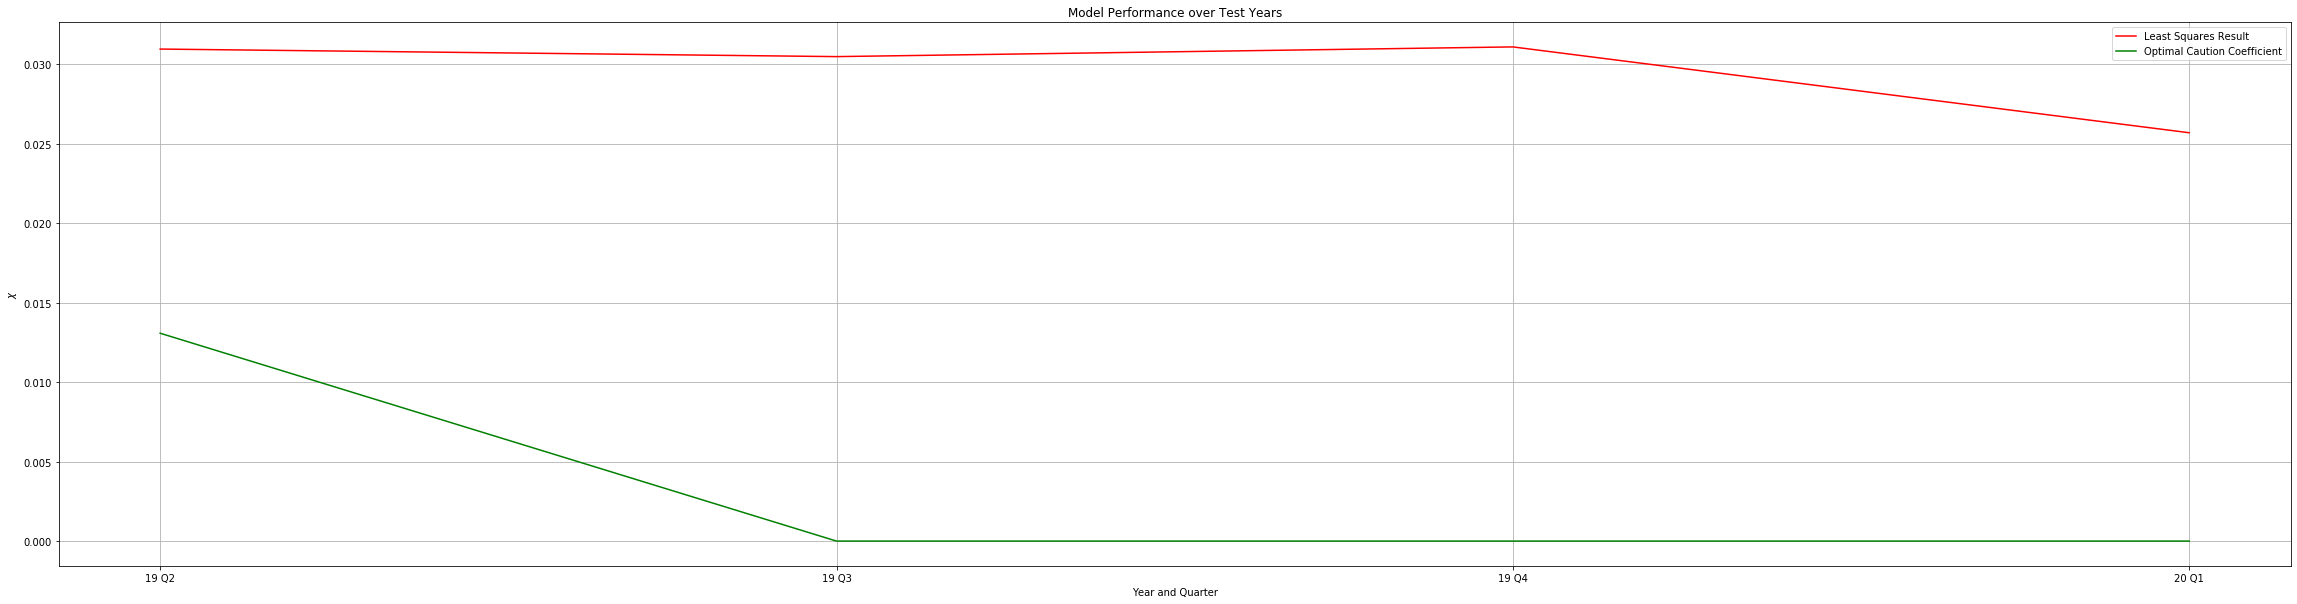

In [162]:
test = np.zeros((4,7))

for i in range(52,56):
    test[i-52,:] = [1, -SNR_lt[i+1], -omega_v_st[i+1], -lt_prx[i+1], -lt_prx[i], -st_lev[i+1], -st_lev[i]]

plt.figure(figsize=(40,10))
plt.plot(rolling_quarter_index[53:57], test@ls_results, 'r', label='Least Squares Result')
plt.plot(rolling_quarter_index[53:57], list(optimal_caution.values())[53:57], 'g', label='Optimal Caution Coefficient')
plt.ylabel('$\chi$')
plt.xlabel('Year and Quarter')
plt.title('Model Performance over Test Years')
plt.grid()
plt.legend()
plt.show()